## Задание Basic code.
## По мотивам статьи: 2014 - On the Importance of Text Analysis for Stock Price Prediction

In [2]:
# load modules

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
from scipy.sparse import hstack, vstack
import pandas as pd
import re
import datetime
import time

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score  # quality measure from paper

from sklearn.ensemble import RandomForestClassifier  # basic classifier from paper
from sklearn.decomposition import NMF, LatentDirichletAllocation

#from sklearn.preprocessing import LabelEncoder

In [3]:
time_ = time.time()

# tickers for {Apple, Adobe, Amazon, Google, HP, IBM, Intel, MicroSoft, NVidia}
tickers = ['AAPL', 'ADBE', 'AMZN', 'GOOG', 'HPQ', 'IBM', 'INTC', 'MSFT', 'NVDA']
sp500_ticker = 'gspc' # S&P500 ticker from paper

reports_dataset = pd.DataFrame(columns=['ticker', 'date', 'time', 'text', 'movement', 'movement_normalized', 'label'])

for iter_, ticker in enumerate(tickers):
    ############################################
    ################## PART 1 ##################
    ############################################
    
    print('iteration %i of %i | ticker: %s' % (iter_+1, len(tickers), ticker))
    
    # load data
    
    # 1. stock quotes
    price = pd.read_csv('data/price_history/'+ticker+'.csv')
    price = price[price['Date'] > '2001-12-31']
    price = price.sort_values('Date').reset_index(drop=True)
    sp500 = pd.read_csv('data/price_history/'+sp500_ticker+'.csv')
    sp500 = sp500[sp500['Date'] > '2001-12-31']
    sp500 = sp500.sort_values('Date').reset_index(drop=True)

    # 2. 8K reports
    f = open('data/8K/'+ticker, 'r')
    f_lines = f.readlines()
    f.close()
    raw_8k_reports = pd.Series(' '.join(f_lines).split('</DOCUMENT>')[:-1])

    def transform_8k_report_to_dataframe(report):
        # transform 8k report to pd.DataFrame row
        #
        # report: string
        # result: pd.DataFrame

        result = pd.DataFrame(columns=['ticker', 'date', 'time', 'text'], index=[0])

        result['ticker'] = report.split('FILE:')[1].split('/')[0]

        datetime_ = report.split('TIME:')[1].split('\n')[0]
        datetime_ = datetime.datetime.strptime(datetime_, '%Y%m%d%H%M%S')
        result['date'] = str(datetime_.date())  # date in format 'yyyy-mm-dd'
        result['time'] = str(datetime_.time())  # time in format 'hh:mm:ss'

        # Leave only the part of text
        text = report.split('ITEM:')[-1]
        # Delete unnecessary sentences
        text = text.replace('QuickLinks', '').replace('Click here to rapidly navigate through this document', '')
        # Delete '\n' & etc. Leave out only text of report
        text = ' '.join(text.split())
        result['text'] = text

        return result

    reports = pd.DataFrame(columns=[])
    for report in raw_8k_reports:
        row = transform_8k_report_to_dataframe(report)
        reports = pd.concat([reports, row], axis=0)
    reports.reset_index(drop=True, inplace=True)

    del f_lines, raw_8k_reports, report
    
    
    ############################################
    ################## PART 2 ##################
    ############################################
    
    # create binary markup {MOVE, STAY} for price data
    # aggregate UP and DOWN labels to MOVE label

    price_movement = pd.DataFrame(columns=['date', 'movement', 'movement_normalized', 'label'])

    # i = row num, j = row values
    for i, j in price.iloc[:-1,:].iterrows():
        row = pd.DataFrame(columns=['date', 'movement', 'movement_normalized', 'label'], index=[0])
        row['date'] = j['Date']

        column_next = 'Open'  # value from paper
        column_prev = 'Close'  # value from paper
        price_change = (price.loc[i+1, column_next] - price.loc[i, column_prev]) / price.loc[i, column_prev]
        sp500_change = (sp500.loc[i+1, column_next] - sp500.loc[i, column_prev]) / sp500.loc[i, column_prev]
        row['movement'] = price_change

        price_change_normalized = price_change - sp500_change  # price_change normalization, described in paper
        row['movement_normalized'] = price_change_normalized

        if price_change_normalized >= 0.01: # value from paper
            row['label'] = 'UP'  # price movement: UP
        elif price_change_normalized <= -0.01: # value from paper
            row['label'] = 'DOWN'  # price movement: DOWN
        else:
            row['label'] = 'STAY'  # price movement: STAY
            
        #le = LabelEncoder()
        #row['label'] = le.fit(['UP', 'DOWN', 'STAY']).transform(row['label'])

        price_movement = pd.concat([price_movement, row], axis=0)

    price_movement.reset_index(drop=True, inplace=True)

    del price, sp500
    
    # merge stock quotes and text

    reports = pd.merge(reports, price_movement, on='date', how='left')
    reports.dropna(axis=0, inplace=True)

    del price_movement
    
    # combine tickers
    
    reports_dataset = pd.concat([reports_dataset, reports], axis=0)
    
    del reports

reports_dataset.reset_index(drop=True, inplace=True)
print('finished. time elapsed: %.2f sec' % (time.time() - time_))

iteration 1 of 9 | ticker: AAPL
iteration 2 of 9 | ticker: ADBE
iteration 3 of 9 | ticker: AMZN
iteration 4 of 9 | ticker: GOOG
iteration 5 of 9 | ticker: HPQ
iteration 6 of 9 | ticker: IBM
iteration 7 of 9 | ticker: INTC
iteration 8 of 9 | ticker: MSFT
iteration 9 of 9 | ticker: NVDA
finished. time elapsed: 236.08 sec


In [4]:
reports_dataset

,ticker,date,time,text,movement,movement_normalized,label
0,AAPL,2002-08-02,18:59:57,Financial statements and exhibits -- Items 1 t...,0.004152,0.004152,STAY
1,AAPL,2002-08-13,16:47:30,Financial statements and exhibits -- Items 1 t...,0.005483,0.005483,STAY
2,AAPL,2003-03-20,19:36:01,Financial statements and exhibits Items 1 thro...,0.012072,0.011878,UP
3,AAPL,2003-04-16,16:21:56,Regulation FD Disclosure -- Item 7. Financial ...,-0.003021,-0.003021,STAY
4,AAPL,2003-07-16,16:04:06,Regulation FD Disclosure Item 7. Financial Sta...,0.016105,0.016195,UP
5,AAPL,2003-10-15,16:29:50,Financial statements and exhibits Item 7. Fina...,-0.041096,-0.041096,DOWN
6,AAPL,2004-01-14,16:30:52,Financial statements and exhibits Item 7. Fina...,-0.053306,-0.053306,DOWN
7,AAPL,2004-04-14,16:27:33,Financial statements and exhibits Item 7. Fina...,0.081832,0.081832,UP
8,AAPL,2004-07-14,16:29:34,Financial statements and exhibits Item 7. Fina...,0.104124,0.104124,UP
9,AAPL,2004-10-13,16:31:13,Financial Statements and Exhibits Check the ap...,0.086541,0.086541,UP


In [5]:
############################################
################## PART 3 ##################
############################################

# split data to train / validation / test

# features
train_start, train_end = '2001-12-31', '2008-12-31'  # train period from paper
x_train = reports_dataset[(train_start < reports_dataset['date']) & (reports_dataset['date'] <= train_end)]['text']

val_start, val_end = '2008-12-31', '2010-12-31'  # validation period from paper
x_val = reports_dataset[(val_start < reports_dataset['date']) & (reports_dataset['date'] <= val_end)]['text']

test_start, test_end = '2010-12-31', '2012-12-31'  # test period from paper
x_test = reports_dataset[(test_start < reports_dataset['date']) & (reports_dataset['date'] <= test_end)]['text']

# target variable
y_train = reports_dataset[(train_start < reports_dataset['date']) & (reports_dataset['date'] <= train_end)]['label']
y_val = reports_dataset[(val_start < reports_dataset['date']) & (reports_dataset['date'] <= val_end)]['label']
y_test = reports_dataset[(test_start < reports_dataset['date']) & (reports_dataset['date'] <= test_end)]['label']

In [6]:
x_train

0       Financial statements and exhibits -- Items 1 t...
1       Financial statements and exhibits -- Items 1 t...
2       Financial statements and exhibits Items 1 thro...
3       Regulation FD Disclosure -- Item 7. Financial ...
4       Regulation FD Disclosure Item 7. Financial Sta...
5       Financial statements and exhibits Item 7. Fina...
6       Financial statements and exhibits Item 7. Fina...
7       Financial statements and exhibits Item 7. Fina...
8       Financial statements and exhibits Item 7. Fina...
9       Financial Statements and Exhibits Check the ap...
10      Results of Operations and Financial Condition ...
11      Financial Statements and Exhibits Check the ap...
12      Other Events Check the appropriate box below i...
13      Amendments to Articles of Incorporation or Byl...
14      Financial Statements and Exhibits Check the ap...
15      Entry into a Material Definitive Agreement Che...
16      Other Events Check the appropriate box below i...
17      Financ

In [12]:
# indices of top words after Tf-Idf vectorization
n_first = 1000
n_last = 1100
top_idx = np.ravel(unigrams_train_features.sum(axis=0).argsort(axis=1))[::-1][n_first:n_last] #- top 5
top_values = np.sort(np.ravel(unigrams_train_features.sum(axis=0)))[::-1][n_first:n_last].tolist()
top_words = np.array(vectorizer.get_feature_names())[top_idx].tolist()
len(top_idx)

100

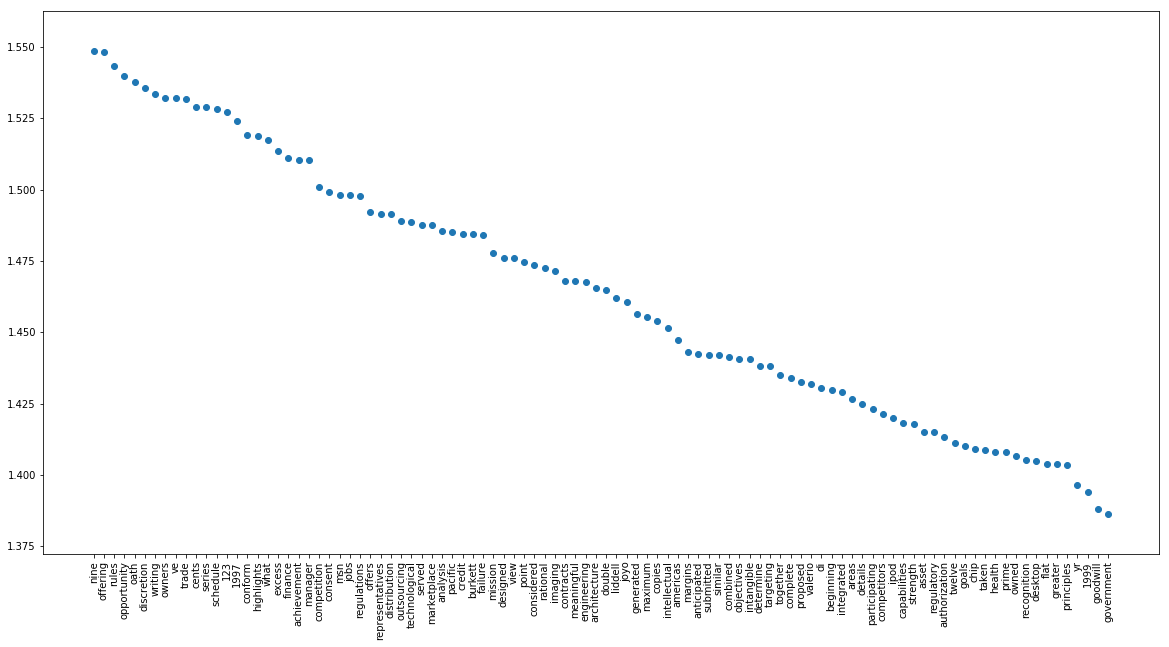

In [13]:
plt.figure(figsize=(20,10))
plt.scatter(top_words, top_values)
plt.xticks(rotation=90);

array([2.85317359e+02, 1.87254248e+02, 1.38676469e+02, ...,
       5.14997287e-04, 5.14997287e-04, 5.14997287e-04])

In [20]:
np.quantile(np.sort(np.ravel(unigrams_train_features.sum(axis=0)))[::-1], 0.95)

1.9146724040163547

In [13]:
nmf_50_train_features

array([[0.01780573, 0.00084522, 0.        , ..., 0.        , 0.06910726,
        0.        ],
       [0.02729958, 0.        , 0.00153753, ..., 0.01382526, 0.        ,
        0.00857608],
       [0.0471225 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.03096256, 0.        , 0.26852004, ..., 0.        , 0.        ,
        0.01880195],
       [0.04953807, 0.00305349, 0.03181768, ..., 0.        , 0.        ,
        0.        ],
       [0.03096256, 0.        , 0.26852004, ..., 0.        , 0.        ,
        0.01880195]])

In [7]:
############################################
################## PART 4 ##################
############################################

time_ = time.time()

# create features

# 1. Unigrams
# example: vectorizer_params = {}
#          vectorizer = Vectorizer(**vectorizer_params)
#          unigrams_train_features = vectorizer.fit_transform(x_train)
# ...
#vectorizer = CountVectorizer()
vectorizer = TfidfVectorizer()
unigrams_train_features = vectorizer.fit_transform(x_train)
unigrams_val_features = vectorizer.transform(x_val)
unigrams_test_features = vectorizer.transform(x_test)
print('unigrams created')
# To check feature names: vectorizer.get_feature_names()

# 2. NMF vector for 50, 100, and 200 components
# example: nmf_params = {}
#          nmf = NMF(**nmf_params)
#          nmf_train_features = nmf.fit_transform(unigrams_train_features)

nmf50 = NMF(50)
nmf_50_train_features = nmf50.fit_transform(unigrams_train_features)
nmf_50_val_features = nmf50.transform(unigrams_val_features)
nmf_50_test_features = nmf50.transform(unigrams_test_features)
print('nmf 50 features created')
# To check matrix shape: nmf_50_train_features.shape

nmf100 = NMF(100)
nmf_100_train_features = nmf100.fit_transform(unigrams_train_features)
nmf_100_val_features = nmf100.transform(unigrams_val_features)
nmf_100_test_features = nmf100.transform(unigrams_test_features)
print('nmf 100 features created')

nmf200 = NMF(200)
nmf_200_train_features = nmf200.fit_transform(unigrams_train_features)
nmf_200_val_features = nmf200.transform(unigrams_val_features)
nmf_200_test_features = nmf200.transform(unigrams_test_features)
print('nmf 200 features created')
print('finished. time elapsed: %.2f sec' % (time.time() - time_))

unigrams created
nmf 50 features created
nmf 100 features created
nmf 200 features created
finished. time elapsed: 732.21 sec


In [8]:
############################################
################## PART 5 ##################
############################################

# combine all features to one feature space

# 1. NMF 50 features
nmf_50_x_train = hstack([unigrams_train_features, 
                         nmf_50_train_features])

nmf_50_x_val = hstack([unigrams_val_features,   
                       nmf_50_val_features])

nmf_50_x_test = hstack([unigrams_test_features,  
                        nmf_50_test_features])

# 2. NMF 100 features
nmf_100_x_train = hstack([unigrams_train_features, 
                         nmf_100_train_features])

nmf_100_x_val = hstack([unigrams_val_features,   
                       nmf_100_val_features])

nmf_100_x_test = hstack([unigrams_test_features,  
                        nmf_100_test_features])

# 3. NMF 200 features
nmf_200_x_train = hstack([unigrams_train_features, 
                         nmf_200_train_features])

nmf_200_x_val = hstack([unigrams_val_features,   
                       nmf_200_val_features])

nmf_200_x_test = hstack([unigrams_test_features,  
                        nmf_200_test_features])

# 4. Ensemble features
ensemble_x_train = hstack([unigrams_train_features, 
                           nmf_50_train_features, 
                           nmf_100_train_features, 
                           nmf_200_train_features])

ensemble_x_val = hstack([unigrams_val_features, 
                           nmf_50_val_features, 
                           nmf_100_val_features, 
                           nmf_200_val_features])

ensemble_x_test = hstack([unigrams_test_features, 
                           nmf_50_test_features, 
                           nmf_100_test_features, 
                           nmf_200_test_features])

In [7]:
############################################
################## PART 6 ##################
############################################

time_ = time.time()

# set basic classifier parameters, fit classifiers. 
# Hint: initialize new basic classifier before new training process

# example: basic_classifier_params = {}
#          basic_classifier = BasicClassifier(**basic_classifier_params)


# 1. Unigrams
# example: rf_unigrams_model = ...
# ...
#basic_classifier = BasicClassifier(**basic_classifier_params)
#clf = RandomForestClassifier(n_estimators=10, max_depth=None,
#                             min_samples_split=2, random_state=0)
rf_unigrams_model = RandomForestClassifier()
rf_unigrams_model.fit(unigrams_train_features, y_train)
#print(clf.feature_importances_)
#scores = cross_val_score(clf, X, y, cv=5)
#scores.mean()
print('rf_unigrams_model trained')

# 2. NMF 50
rf_nmf_50_model = RandomForestClassifier(n_estimators=2000)
rf_nmf_50_model.fit(nmf_50_x_train, y_train)

print('rf_nmf_50_model trained')

# 3. NMF 100
rf_nmf_100_model = RandomForestClassifier(n_estimators=2000)
rf_nmf_100_model.fit(nmf_100_x_train, y_train)

print('rf_nmf_100_model trained')

# 4. NMF 200
rf_nmf_200_model = RandomForestClassifier(n_estimators=2000)
rf_nmf_200_model.fit(nmf_200_x_train, y_train)

print('rf_nmf_200_model trained')

# 5. Ensemble
rf_ensemble_model = RandomForestClassifier(n_estimators=2000)
rf_ensemble_model.fit(ensemble_x_train, y_train)

print('rf_ensemble_model trained')
print('finished. time elapsed: %.2f sec' % (time.time() - time_))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

rf_unigrams_model trained


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

rf_nmf_50_model trained


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

rf_nmf_100_model trained


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

rf_nmf_200_model trained


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

rf_ensemble_model trained
finished. time elapsed: 384.90 sec


In [8]:
############################################
################## PART 7 ##################
############################################

# calculate quality measures

# 1. Unigrams
# example: rf_unigrams_quality = Quality(y_true, y_pred)
rf_unigrams_quality = accuracy_score(y_val, rf_unigrams_model.predict(unigrams_val_features))

# 2. NMF 50
rf_nmf_50_quality = accuracy_score(y_val, rf_nmf_50_model.predict(nmf_50_x_val))

# 3. NMF 100
rf_nmf_100_quality = accuracy_score(y_val, rf_nmf_100_model.predict(nmf_100_x_val))

# 4. NMF 200
rf_nmf_200_quality = accuracy_score(y_val, rf_nmf_200_model.predict(nmf_200_x_val))

# 5. Ensemble
rf_ensemble_quality = accuracy_score(y_val, rf_ensemble_model.predict(ensemble_x_val))

# save results
results = pd.DataFrame({'model': ['rf_unigrams_model', 'rf_nmf_50_model', 
                                  'rf_nmf_100_model', 'rf_nmf_200_model', 'rf_ensemble_model'], 
                        'n_features': [rf_unigrams_model.n_features_, rf_nmf_50_model.n_features_, 
                                       rf_nmf_100_model.n_features_, rf_nmf_200_model.n_features_, 
                                       rf_ensemble_model.n_features_], 
                        'accuracy': [rf_unigrams_quality, rf_nmf_50_quality, 
                                     rf_nmf_100_quality, rf_nmf_200_quality, rf_ensemble_quality]}, 
                       columns=['model', 'n_features', 'accuracy'])
results.to_csv('data/results.csv', index=False)
results

,model,n_features,accuracy
0,rf_unigrams_model,16420,0.582222
1,rf_nmf_50_model,16470,0.653333
2,rf_nmf_100_model,16520,0.666667
3,rf_nmf_200_model,16620,0.648889
4,rf_ensemble_model,16770,0.662222
